In [1]:
def reproduceResult():
  seed_value= 0

  
  with tf.device("/gpu:0"):
    ...


  os.environ['PYTHONHASHSEED']=str(seed_value)
  np.random.seed(0)
  rn.seed(0)


  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                          inter_op_parallelism_threads=1)


  tf.compat.v1.set_random_seed(seed_value)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  tf.compat.v1.keras.backend.clear_session()

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import os 
import numpy as np
import tensorflow as tf
import random as rn
from tensorflow import keras

reproduceResult()
# %tensorflow_version 2.x
# import tensorflow as tf
# tf.test.gpu_device_name()
# from scipy import integrate
# import os
# import numpy as np
# from tensorflow import keras
import tempfile
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K


from tensorflow.keras import callbacks

from keras_lr_finder import LRFinder
from clr.clr_callback import CyclicLR

import tensorflow_model_optimization as tfmot

import tqdm

import keras_tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from attention import Attention

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math


from keras.preprocessing.text import Tokenizer


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing

from bnlp import SentencepieceTokenizer
import gensim
import fasttext 

C:\Users\moshi\AppData\Local\Temp\ipykernel_16804\2832172220.py:43: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
df = pd.read_excel('F:/Context_Aware_Data_Cleaning_Deep/UBMEC/Dataset/UBMEC.xlsx')

In [4]:
df.head

<bound method NDFrame.head of                                                     text   classes
0      এই নাটকটি হচ্ছে ১৯৯৩ সালের। কিন্তু তখন ইউটিউব ...       joy
1      ২০২১ সালে যারা “ কোথাও কেউ নেই ” দেখতে আসে - ত...  surprise
2      বাংলাদেশের ইতিহাসে সর্বশ্রেষ্ঠ নাটক "কোথাও কেউ...       joy
3      এতো সুন্দর নাটক আগে কখনো দেখা হয় নাই,2021 সালে...       joy
4      কখনো চিন্তাও করিনি জন্মের ৭-৮ বছর আগের নাটক দে...  surprise
...                                                  ...       ...
13431  Bravo বললে ছোট করা হবে ৷ সুতরাং হাজারো সালাম আ...       joy
13432  কি যে করেন না ম্যাজিস্ট্রেট স্যার? প্রথমটুক পড়...       joy
13433  আপনারা এই সত্যের পথে অবিচল থাকুন দেশবাসী আপনাদ...       joy
13434          এগিয়ে যান। আপনাদের দিকেই তাকিয়ে বাংলাদেশ।       joy
13435  দুর্নীতি মুক্ত হলে নিশ্চয় চোরও মুক্ত হবে, বিশ্...       joy

[13436 rows x 2 columns]>

In [5]:
df.isnull()

,text,classes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
13431,False,False
13432,False,False
13433,False,False
13434,False,False


In [6]:
df.dropna(inplace=True)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from bnlp import NLTKTokenizer

In [8]:
from bnlp import CleanText

clean_text = CleanText(
   fix_unicode=True,
   unicode_norm=True,
   unicode_norm_form="NFKC",
   remove_url=True,
   remove_email=True,
   remove_emoji=False,
   remove_number=False,
   remove_digits=False,
   remove_punct=False,
   replace_with_url="<URL>",
   replace_with_email="<EMAIL>",
   replace_with_number="<NUMBER>",
   replace_with_digit="<DIGIT>",
   replace_with_punct = "<PUNC>"
)

In [9]:
df['text'] = df['text'].apply(clean_text)

In [10]:
df.groupby("classes").describe()

text                                                               
         count unique                                                top freq
classes                                                                      
anger     2480   2422     নাস্তিকদের দালাল একাওর টিভি বন্ধ করা হোক,<URL>    6
disgust   2079   2049  অপরাধ কারী এবং অপরাধী কে প্রশ্রয় দানকারী দুজন...    6
fear      1361   1348  হট্রগোল আর পরিস্থিতি ঘোলাটে করে নির্বাহী মেজিস...    2
joy       3467   3289                                            ধন্যবাদ   27
sadness   2683   2622  অপরাধ কারী এবং অপরাধী কে প্রশ্রয় দানকারী দুজন...   12
surprise  1366   1341  আমরা কি স্ট্যাটাসের বাকি লাইনগুলো অস্বীকার করব...    4

In [11]:
df["classes"].value_counts()

joy         3467
sadness     2683
anger       2480
disgust     2079
surprise    1366
fear        1361
Name: classes, dtype: int64

In [12]:
df['text'] = df['text'].astype(str)

In [13]:
train, test = train_test_split(df, test_size=0.2, stratify = df["classes"], random_state = 42)
num_classes = 6
embed_num_dims = 300
max_seq_len = 50

x_train = train['text']
x_test = test['text']

y_train = train['classes']
y_test = test['classes']

texts_train = x_train
texts_test = x_test

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len, padding='pre' )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len,  padding='pre')

print(X_train_pad)


encoding = {
    "joy":0,
    "disgust":1,
    "sadness":2,
    "anger":3,
    "fear":4,
    "surprise":5
}

y_train = [encoding[x] for x in train['classes']]
y_test = [encoding[x] for x in test['classes']]



y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


Number of unique words: 32532
[[    0     0     0 ...   259   502   109]
 [    0     0     0 ...  2340    44   553]
 [    0     0     0 ...   358    45 13230]
 ...
 [    0     0     0 ...    19    85  4561]
 [    0     0     0 ...    15    42   440]
 [    0     0     0 ...  2606 32532    43]]


In [14]:
# META EMBADDING

In [15]:
def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open('F:/Python_code/embedding/glove.840B.300d.txt', encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                try:
                    idx = word_index[word]
                    embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
                except ValueError:
                    pass
    return embedding_matrix

embedd_matrix_glove = create_embedding_matrix(index_of_words, embed_num_dims)
print(embedd_matrix_glove.shape)

(32533, 300)


# Random Search

In [16]:
from tensorflow.keras import regularizers
import time
LOG_DIR = f"{int(time.time())}"
seed_value= 0



def build_model(hp):
  
  reproduceResult()

  print('Ya it comes here')
  fake_val = hp.Int("cnn_1_unit",min_value =16, max_value = 96, step = 16)
  cnn_1_unit = hp.Int("cnn_1_unit",min_value =16, max_value = 96, step = 16)
  cnn_1_dropout = hp.Float("cnn_1_dropout",min_value = 0.1,max_value = 0.3,step = 0.1)

  lstm_unit = hp.Int("lstm_unit",min_value =64, max_value = 256, step = 32)
  lstm_dropout = hp.Float("lstm_dropout",min_value = 0.1,max_value = 0.5,step = 0.1)




  seq_input = keras.layers.Input(shape=(max_seq_len,))

  embedded = keras.layers.Embedding(vocab_size,
                          embed_num_dims,
                          input_length = max_seq_len,
                          weights = [embedd_matrix_glove])(seq_input)

  cnn = keras.layers.Conv1D(cnn_1_unit,3,kernel_regularizer=regularizers.l2(1e-4),
                            bias_regularizer=regularizers.l2(1e-2),
                            activity_regularizer=regularizers.l2(1e-4))(embedded)
  cnn = keras.layers.Activation(activation='relu')(cnn)
  cnn = keras.layers.BatchNormalization()(cnn)
  cnn = keras.layers.Dropout(cnn_1_dropout,seed=seed_value)(cnn)
  
  max_pooling = keras.layers.GlobalMaxPooling1D()(cnn)
  output = keras.layers.Dense(num_classes, activation='softmax')(max_pooling)

  model = keras.Model(inputs = [seq_input], outputs = output)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model


stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              restore_best_weights=True,
                              verbose=0, mode='max')


clr_step_size = int((len(X_train_pad)/64))
base_lr = 1e-3
max_lr = 6e-3
mode = 'exp_range'


clr = CyclicLR(base_lr = base_lr, max_lr = max_lr, step_size = clr_step_size, mode = mode)



tuner = RandomSearch(
    build_model,
    objective = keras_tuner.Objective('val_accuracy', direction="max"),
    max_trials = 30,
    executions_per_trial = 1,
    directory = LOG_DIR
    )
  
tuner.search(x=X_train_pad,y = y_train,epochs = 30, batch_size = 64,callbacks = [stop,clr], 
             validation_data = (X_test_pad,y_test))


tuner.results_summary()

Trial 30 Complete [00h 00m 19s]
val_accuracy: 0.4996279776096344

Best val_accuracy So Far: 0.5141369104385376
Total elapsed time: 00h 11m 49s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1708194336\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 28 summary
Hyperparameters:
cnn_1_unit: 64
cnn_1_dropout: 0.1
lstm_unit: 128
lstm_dropout: 0.5
Score: 0.5141369104385376

Trial 15 summary
Hyperparameters:
cnn_1_unit: 96
cnn_1_dropout: 0.2
lstm_unit: 160
lstm_dropout: 0.30000000000000004
Score: 0.511904776096344

Trial 17 summary
Hyperparameters:
cnn_1_unit: 96
cnn_1_dropout: 0.2
lstm_unit: 192
lstm_dropout: 0.5
Score: 0.5078125

Trial 16 summary
Hyperparameters:
cnn_1_unit: 64
cnn_1_dropout: 0.1
lstm_unit: 128
lstm_dropout: 0.1
Score: 0.5070684552192688

Trial 18 summary
Hyperparameters:
cnn_1_unit: 96
cnn_1_dropout: 0.2
lstm_unit: 96
lstm_dropout: 0.2
Score: 0.5063244104385376

Trial 23 summary
Hyperparameters:
cnn_1_unit: 8

In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_1_unit (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
cnn_1_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
lstm_unit (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
lstm_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [18]:
#get best hypoerparamter
best_hps = tuner.get_best_hyperparameters()[0]
model = build_model(best_hps)

Ya it comes here


In [19]:
history = model.fit(x=X_train_pad,y = y_train,epochs = 30, batch_size = 64,callbacks = [stop,clr], 
             validation_data = (X_test_pad,y_test))

Epoch 1/30
168/168 [==============================] - 2s 10ms/step - loss: 1.9877 - accuracy: 0.3986 - val_loss: 1.6807 - val_accuracy: 0.3069
Epoch 2/30
168/168 [==============================] - 2s 10ms/step - loss: 0.7547 - accuracy: 0.7766 - val_loss: 1.4348 - val_accuracy: 0.4993
Epoch 3/30
168/168 [==============================] - 2s 9ms/step - loss: 0.2478 - accuracy: 0.9548 - val_loss: 1.6423 - val_accuracy: 0.4792
Epoch 4/30
168/168 [==============================] - 2s 9ms/step - loss: 0.2693 - accuracy: 0.9558 - val_loss: 1.8083 - val_accuracy: 0.5011
Epoch 5/30
168/168 [==============================] - 2s 9ms/step - loss: 0.1368 - accuracy: 0.9833 - val_loss: 2.1193 - val_accuracy: 0.4810
Epoch 6/30
168/168 [==============================] - 2s 10ms/step - loss: 0.1942 - accuracy: 0.9755 - val_loss: 2.0429 - val_accuracy: 0.4944
Epoch 7/30
168/168 [==============================] - 2s 9ms/step - loss: 0.1186 - accuracy: 0.9861 - val_loss: 2.2336 - val_accuracy: 0.4926
Epo

In [20]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

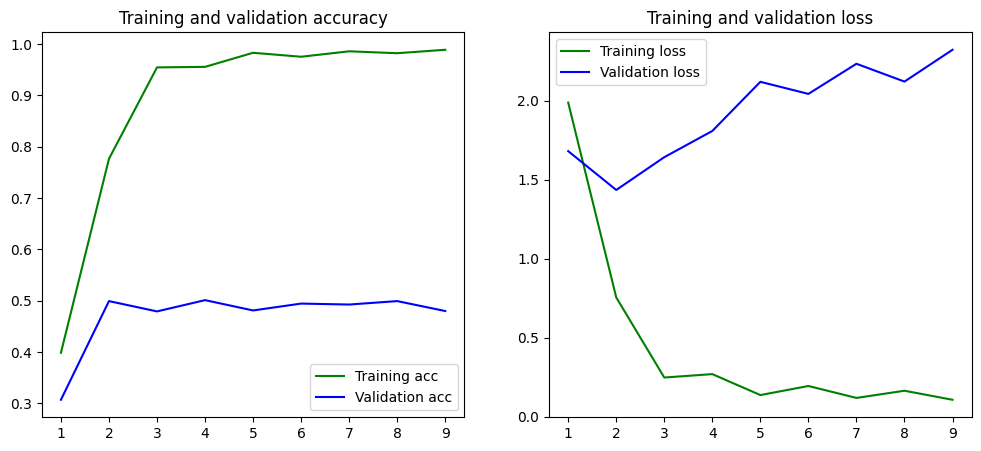

In [21]:
PlotGraph(history)

In [22]:
predict = model.predict(X_test_pad)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

84/84 [==============================] - 0s 1ms/step


array([5, 1, 0, ..., 4, 3, 3], dtype=int64)

In [23]:
predict_lables=np.argmax(y_test, axis=1)
predict_lables

array([4, 3, 0, ..., 2, 2, 1], dtype=int64)

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predict_lables, predict_class)
cm

array([[496,  44,  82,  19,  20,  33],
       [ 43, 137, 106,  63,  24,  43],
       [ 82,  72, 266,  43,  34,  40],
       [ 57,  79,  88, 211,  25,  36],
       [ 26,  18,  52,  14, 143,  19],
       [ 38,  33,  61,  31,  16,  94]], dtype=int64)

In [25]:
class_names = list(encoding.keys())

In [26]:
print(class_names)

['joy', 'disgust', 'sadness', 'anger', 'fear', 'surprise']


<Axes: >

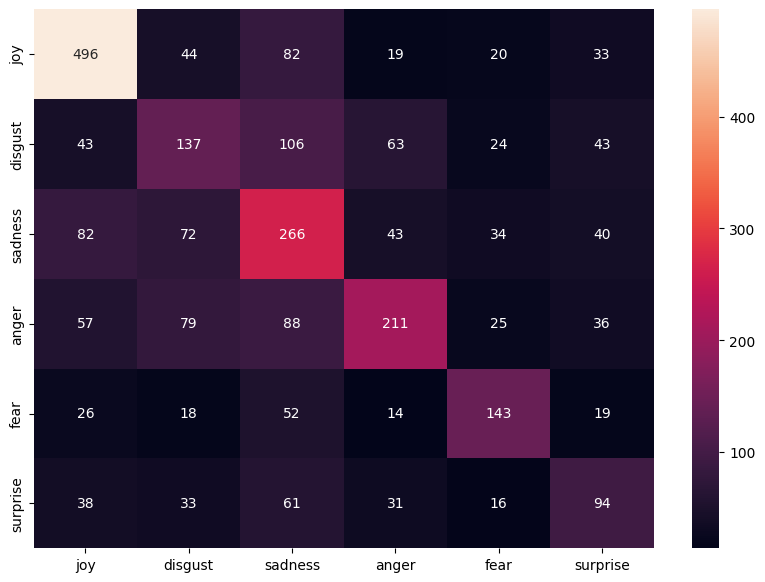

In [27]:
df_cm = pd.DataFrame(cm, index=class_names,columns=class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [28]:
from sklearn.metrics import classification_report
print(classification_report(predict_lables, predict_class, target_names =class_names))

              precision    recall  f1-score   support

         joy       0.67      0.71      0.69       694
     disgust       0.36      0.33      0.34       416
     sadness       0.41      0.50      0.45       537
       anger       0.55      0.43      0.48       496
        fear       0.55      0.53      0.54       272
    surprise       0.35      0.34      0.35       273

    accuracy                           0.50      2688
   macro avg       0.48      0.47      0.47      2688
weighted avg       0.50      0.50      0.50      2688

